<a href="https://www.kaggle.com/code/mosesmakola/sickle-cell-cnn-classifier?scriptVersionId=205818826" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

Sickle cell is an inherited disorder of haemoglobin in the red blood cells and can only be inherited from both parents passing on the sickle cell trait.

1 in 4 people of West African heritage have the sickle cell trait and 1 in 10 people of Caribbean heritage have the sickle cell trait [Sickle Cell Society, 2021].

The goal of this project is to classify sickle cell images using a CNN model.

The dataset comprises of 422 positive (sickle cell) images (labelled and unlabelled) and 147 negative images.

The images were collected from the Teso region in Uganda where 140 patients provided their blood samples collected through field stains and leichman stains.

# Data Exploration and Preprocessing

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Creating Class for the dataset, inherits from Dataset superclass from pytorch
class SickleCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load images from Clear (Negative) and Labelled (Positive)
        clear_path = os.path.join(root_dir, "Negative", "Clear")
        labelled_path = os.path.join(root_dir, "Positive", "Labelled")
    
        # Load negative images and append label
        for img_name in os.listdir(clear_path):
            self.image_paths.append(os.path.join(clear_path, img_name))
            self.labels.append(0) # Label for negative class

        # Load positive images and append label
        for img_name in os.listdir(labelled_path):
            self.image_paths.append(os.path.join(labelled_path, img_name))
            self.labels.append(1)

    # Custom defined len method to retrieve length of dataset
    def __len__(self):
        return len(self.image_paths)

    # Custom defined label_count method to retrive count of a specified label (0: negative, 1: positive)
    def label_count(self, label):
        return self.labels.count(label)

    # Returns a specified dataset item (image, label)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [2]:
"""
Defining the transformations to be used on the images:
Resize: changes image sizes to 128x128 to standardise sizing of the images
toTensor: converts image to PyTorch tensor (pixel values from range [0, 255] to [0, 1])
Normalize: adjusts each channel (r, g, b) based on provided mean and std
"""
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [3]:
# Initialises SickleCellDataset with images from root directory and passes the previously defined transformation
dataset = SickleCellDataset(root_dir="/kaggle/input/sickle-cell-disease-dataset", transform = transform)

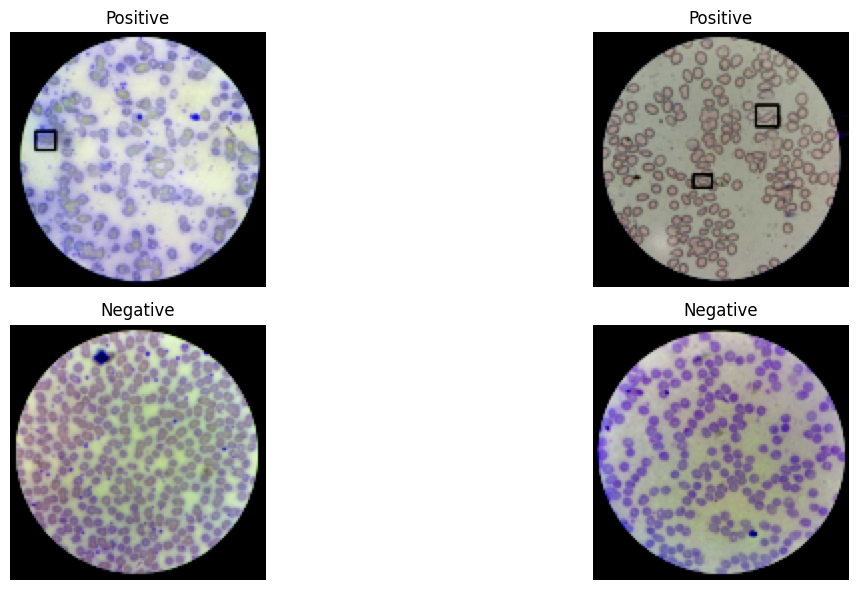

In [4]:
import matplotlib.pyplot as plt

# Function to display a specified number of positive and negative images
def display_sample_images(dataset, num_pos, num_neg):
    pos_count = 0
    neg_count = 0
    fig, axes = plt.subplots(2, max(num_pos, num_neg), figsize=(15, 6))
    
    i = 0
    for image, label in dataset:
        if label == 1 and pos_count < num_pos:  # Positive class
            axes[0, pos_count].imshow(image.permute(1, 2, 0))  # Display image
            axes[0, pos_count].set_title("Positive")
            axes[0, pos_count].axis('off')
            pos_count += 1
        elif label == 0 and neg_count < num_neg:  # Negative class
            axes[1, neg_count].imshow(image.permute(1, 2, 0))  # Display image
            axes[1, neg_count].set_title("Negative")
            axes[1, neg_count].axis('off')
            neg_count += 1
        if pos_count == num_pos and neg_count == num_neg:
            break

    plt.tight_layout()
    plt.show()

# Display 5 positive and 5 negative images
display_sample_images(dataset, num_pos=2, num_neg=2)

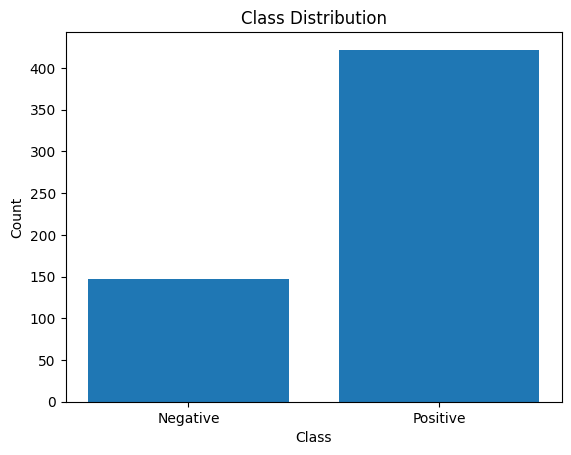

Number of Total samples: 569
Number of Negative samples: 147
Number of Positive samples: 422


In [5]:
import matplotlib.pyplot as plt

# Count the occurrences of each label, store in counts list and define labels
negative_count = dataset.label_count(0)
positive_count = dataset.label_count(1)
counts = [negative_count, positive_count]
labels = ["Negative", "Positive"]

# Plotting the class distribution
plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

# Count the number of total samples and print the number of total, negative and positive samples
total_length = len(dataset)

print(f"Number of Total samples: {total_length}")
print(f"Number of Negative samples: {negative_count}")
print(f"Number of Positive samples: {positive_count}")

There is an imbalance between the classes: there are significantly more positive than negative samples. This could affect the performance of the model as it might become bias towards the majority class (positive)

In [6]:
import torch

# Calculating the mean and std of all negative and positive image pixels
def get_pixel_stats(dataset, label):
    pixels = []
    for img, lbl in dataset:
        if lbl == label:
            pixels.append(img.view(-1))  # Flatten the image
    pixels = torch.cat(pixels)
    return pixels.mean().item(), pixels.std().item()

neg_mean, neg_std = get_pixel_stats(dataset, label=0)
pos_mean, pos_std = get_pixel_stats(dataset, label=1)

print(f"Negative class - Mean: {round(neg_mean, 2)}, Std: {round(neg_std, 2)}")
print(f"Positive class - Mean: {round(pos_mean, 2)}, Std: {round(pos_std, 2)}")

Negative class - Mean: 0.18, Std: 0.62
Positive class - Mean: 0.19, Std: 0.62


## Mean:
Values for both classes are relatively close, ~0.18 for negative and ~0.19 for positive respectively. Both classes have similar brightness or intensity levels across their images. Since the means are not identical this may be a feature the model can learn to differentiate between the two classes.

## Standard Deviation:
Both classes have a std of ~0.62 indicating similar levels of intensity variation within each class. This consistency is beneficial because the model won't have to adjust significantly for one class over the other in terms of brightness or contrast.

---

The close values between the classes suggest that distinguishing features may lie in the shapes, textures or specific regions of the images rather than the overall intensity or contrast

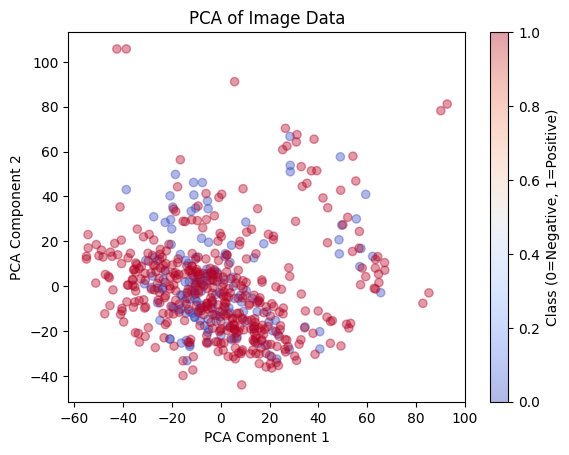

In [7]:
from sklearn.decomposition import PCA

# Flatten images and labels for PCA ()
images = []
labels = []

for i in range(len(dataset)):
    img, label = dataset[i]
    images.append(img.view(-1).numpy()) # Flatten each image and convert to NumPy array
    labels.append(label)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(images)

# Plot PCA result
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.4)
plt.colorbar(label='Class (0=Negative, 1=Positive)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Image Data')
plt.show()

## PCA (Principal Component Analysis)
There is a substantial overlap between the negative and positive points. This overlap suggests that the images do not have a strong separation in the feature space defined by the first two principal components

There is also no clear linear boundary between the two classes. This suggests that the classes are not linearly seperable in this reduced 2D space; a more advanced approach is needed for effective classification

# Data Preperation

In [8]:
from torch.utils.data import random_split

# Define split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [9]:
from torch.utils.data import DataLoader

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Architecture

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SickleCellCNN(nn.Module):
    def __init__(self):
        super(SickleCellCNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)  # Output for 2 classes (Negative and Positive)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 16 * 16)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Output
        return x

In [11]:
# Calculate class weights based on the class imbalance
total_samples = len(dataset)
neg_weight = total_samples / (2 * negative_count)  # for negative samples
pos_weight = total_samples / (2 * positive_count)  # for positive samples

# Create a tensor for class weights
class_weights = torch.tensor([neg_weight, pos_weight], dtype=torch.float)

# Define the weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

### How the weights affect the loss (and counteract the sample imbalance)
The loss function will penalise errors in the minority class more heavily because it has a higher weight.

This encourages the model to pay more attention to correctly predicting the minority class. This increased attention in turn should help even out the inbalance in sample size as the loss from misclassifying from the majority (positive) class is a lot less.

In [12]:
model = SickleCellCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [13]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute weighted loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
        
        # Update running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/20, Loss: 0.7712, Accuracy: 66.58%
Epoch 2/20, Loss: 0.6945, Accuracy: 72.61%
Epoch 3/20, Loss: 0.6932, Accuracy: 71.36%
Epoch 4/20, Loss: 0.6938, Accuracy: 33.42%
Epoch 5/20, Loss: 0.6920, Accuracy: 57.29%
Epoch 6/20, Loss: 0.6890, Accuracy: 55.53%
Epoch 7/20, Loss: 0.6709, Accuracy: 51.51%
Epoch 8/20, Loss: 0.6721, Accuracy: 48.24%
Epoch 9/20, Loss: 0.6030, Accuracy: 75.13%
Epoch 10/20, Loss: 0.5678, Accuracy: 65.58%
Epoch 11/20, Loss: 0.4027, Accuracy: 78.89%
Epoch 12/20, Loss: 0.2276, Accuracy: 88.19%
Epoch 13/20, Loss: 0.1273, Accuracy: 95.98%
Epoch 14/20, Loss: 0.0676, Accuracy: 96.98%
Epoch 15/20, Loss: 0.0258, Accuracy: 99.50%
Epoch 16/20, Loss: 0.0551, Accuracy: 97.74%
Epoch 17/20, Loss: 0.0690, Accuracy: 99.25%
Epoch 18/20, Loss: 0.0251, Accuracy: 98.99%
Epoch 19/20, Loss: 0.0270, Accuracy: 98.99%
Epoch 20/20, Loss: 0.0219, Accuracy: 99.25%


# Evaluation

In [14]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return accuracy

val_accuracy = evaluate(model, val_loader)
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 100.00%


In [15]:
test_accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 97.67%


In [16]:
from torchinfo import summary
summary(model, (3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
SickleCellCNN                            [1, 2]                    --
├─Conv2d: 1-1                            [32, 128, 128]            896
├─Conv2d: 1-2                            [64, 64, 64]              18,496
├─Conv2d: 1-3                            [128, 32, 32]             73,856
├─Linear: 1-4                            [1, 128]                  4,194,432
├─Linear: 1-5                            [1, 2]                    258
Total params: 4,287,938
Trainable params: 4,287,938
Non-trainable params: 0
Total mult-adds (M): 386.14
Input size (MB): 0.20
Forward/backward pass size (MB): 7.34
Params size (MB): 17.15
Estimated Total Size (MB): 24.69

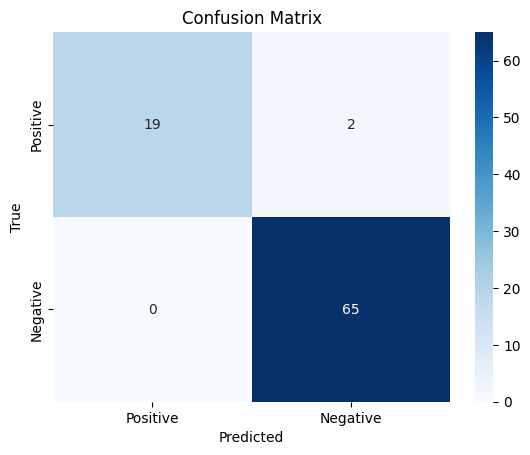

              precision    recall  f1-score   support

    Negative       0.90      1.00      0.95        19
    Positive       1.00      0.97      0.98        67

    accuracy                           0.98        86
   macro avg       0.95      0.99      0.97        86
weighted avg       0.98      0.98      0.98        86



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate on test data
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Confusion Matrix
cm = confusion_matrix(y_pred, y_true)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

# Conclusion

In essence, the created CNN model was successfully able to classify blood samples into two classes (positive sickle cell and negative sickle cell) achieving 97.65% accuracy on the validation dataset and 95.51% on the test dataset.

The models high accuracy and low error rate indicate that it is well-suited to distinguish between sickle cell positibe and negative samples. 

This model's high accuracy and low error rate indicate that it is well-suited to distinguish between sickle cell positive and negative samples. Through data preprocessing, the application of appropriate transformations, and leveraging a weighted loss function to address class imbalance, the model was able to learn discriminative features effectively despite the challenging overlap observed in PCA analysis. The model's use of convolutional layers allowed it to capture relevant spatial patterns and details in the images, which were crucial for classification.

The use of a weighted loss function was instrumental in addressing the class imbalance, ensuring that the model paid sufficient attention to the minority class. The final performance metrics, including precision, recall, and F1-score, show that the model maintains strong classification capabilities across both classes, with a high level of accuracy, precision, and recall even on the minority class.

Moving forward, there are potential avenues to enhance this model further:

1. Data Augmentation: Increasing the variety of traning images through augmentation techniques could futher improve model robustness and reduce overfitting
2. More data and use of unlabelled positives: Testing this model on unlabelled positive images would allow for further evaluation and consolidate the generability of the model for potential real world use cases
3. Early stopping: Stopping the model once performance had plateaued could prevent overfitting and reduce generalisation error
4. Diverse data: All the samples used to train and test this model were collected from the Teso region in Uguanda, this may inadvertently introduce biases to the model and the evaluation of the models performance

While this model may not yet be ready for real-world deployment, an automated sickle cell classification system could play a significant role in addressing healthcare disparities for Black communities in the UK, who are disproportionately affected by sickle cell disease (SCD). Studies show that 42% of Black SCD patients prefer to manage crises at home due to poor hospital experiences, with 56% dissatisfied with emergency care (Sickle Cell World Assessment Survey, 2019). By offering a data-driven, unbiased approach to diagnosis, automated models could support more equitable, timely, and effective care for those affected by SCD.